<a href="https://colab.research.google.com/gist/Muyiiwaa/91712599fa3a3edfe836d6e715b862cc/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# for data wrangling
import pandas as pd
import numpy as np

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# for data modelling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [3]:
data = pd.read_csv('cleaned_marketing.csv')

### DATA WRANGLING

In [4]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [5]:
# inspect missing values

data.isnull().sum()

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0


In [11]:
# check to make sure the data type is right

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Education              2240 non-null   object
 1   Marital_Status         2240 non-null   object
 2   Income                 2240 non-null   object
 3   Kidhome                2240 non-null   int64 
 4   Teenhome               2240 non-null   int64 
 5   Recency                2240 non-null   int64 
 6   MntWines               2240 non-null   int64 
 7   MntFruits              2240 non-null   int64 
 8   MntMeatProducts        2240 non-null   int64 
 9   MntFishProducts        2240 non-null   int64 
 10  MntSweetProducts       2240 non-null   int64 
 11  MntGoldProds           2240 non-null   int64 
 12  NumDealsPurchases      2240 non-null   int64 
 13  NumWebPurchases        2240 non-null   int64 
 14  NumCatalogPurchases    2240 non-null   int64 
 15  NumStorePurchases    

In [7]:
# generate age and duration_of_patronage column

data['customer_age'] = [2024-x for x in data['Year_Birth']]
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['duration_of_patronage'] = [2024 - x.year for x in data['Dt_Customer']]

In [10]:
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,customer_age,duration_of_patronage
0,Graduation,Single,58138,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,67,12
1,Graduation,Single,46344,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,70,10
2,Graduation,Together,71613,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,59,11
3,Graduation,Together,26646,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,40,10
4,PhD,Married,58293,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,43,10


In [9]:
# drop redundant columns
data.drop(columns = ['ID','Year_Birth','Dt_Customer'], inplace = True)

In [23]:
# cast income to numeric data type
data = data[data['Income'] != ' ']
data = data.astype({'Income': 'float'})

In [29]:
# clean the categorical variables
print(f"previous categories: {data['Education'].unique()}")
data['Education'] = ['Bsc' if x == 'Graduation' else
                     'Msc' if x == 'Master' else 'Primary' if x == 'Basic'
                     else 'Ssce' if x == '2n Cycle' else x for x in data['Education']]
print(f"categories after: {data['Education'].unique()}")

previous categories: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
categories after: ['Bsc' 'PhD' 'Msc' 'Primary' 'Ssce']


In [32]:
print(f"previous categories: {data['Marital_Status'].unique()}")
data['Marital_Status'] = ['Single' if x in ['Single','YOLO','Absurd','Alone']
                          else 'dating' if x == 'Together' else x for x in data['Marital_Status']]
print(f"categories after: {data['Marital_Status'].unique()}")

previous categories: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
categories after: ['Single' 'dating' 'Married' 'Divorced' 'Widow']


## DATA VISUALIZATION

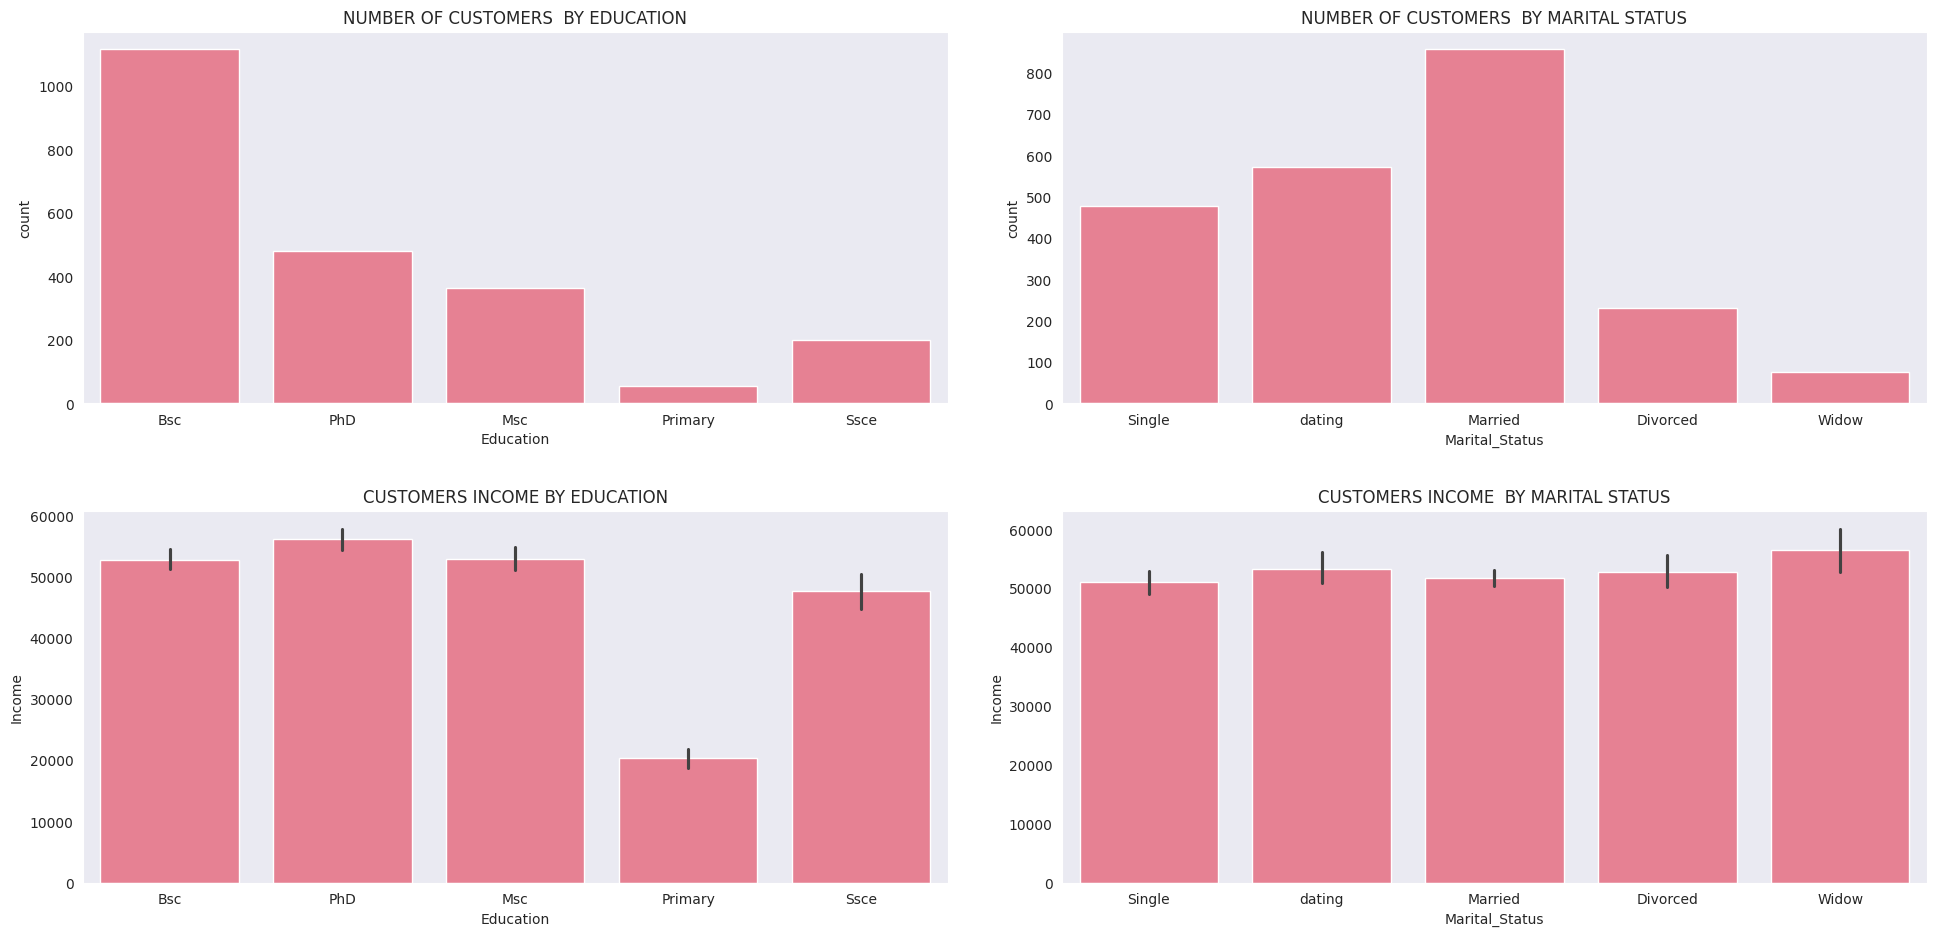

In [39]:
sns.set_style('dark')
sns.set_palette('husl')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.countplot(data = data, x = 'Education', ax=axes[0,0])
sns.countplot(data = data, x = 'Marital_Status', ax=axes[0,1])
sns.barplot(data = data, x = 'Education',y = 'Income', ax=axes[1,0])
sns.barplot(data = data, x = 'Marital_Status',y ='Income', ax=axes[1,1])

axes[0,0].set_title('NUMBER OF CUSTOMERS  BY EDUCATION')
axes[0,1].set_title('NUMBER OF CUSTOMERS  BY MARITAL STATUS')
axes[1,0].set_title('CUSTOMERS INCOME BY EDUCATION')
axes[1,1].set_title('CUSTOMERS INCOME  BY MARITAL STATUS')

fig.tight_layout(pad = 3)

In [ ]:
## check anova to validate the visuals

### DATA MODELLING (customer segmentation)

In [41]:
# encode our data
final_data = data.copy()

encoder = LabelEncoder()

cols = ['Education', 'Marital_Status']
for col in cols:
  data[col] = encoder.fit_transform(data[col])

In [45]:
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,customer_age,duration_of_patronage
0,0,2,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,67,12
1,0,2,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,70,10
2,0,4,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,59,11
3,0,4,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,40,10
4,2,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,43,10


In [ ]:
# scale the dataset
scaler = StandardScaler()
columns = data.columns
data = scaler.fit_transform(data)

In [53]:
data = pd.DataFrame(data = data, columns = list(columns))



In [54]:
# apply pca
columns = ['column1', 'column2','column3']
pca = PCA(n_components=3)
data = pca.fit_transform(data)
data = pd.DataFrame(data=data, columns=columns)

In [55]:
data.head()

,column1,column2,column3
0,3.849476,0.527337,-0.042062
1,-2.405698,-0.259535,-0.487200
2,1.649330,-0.016654,-1.135197
3,-2.535202,-1.622008,-0.022867
4,-0.535915,-0.441032,-0.670374


In [60]:
px.scatter_3d(data_frame=data, x = 'column1',
              y = 'column2', z = 'column3',
              width = 600, color = predictions)

In [57]:
# create cluster

kmeans = KMeans(n_clusters=4, n_init='auto',random_state=23)
predictions = kmeans.fit_predict(data)

In [58]:
predictions

array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

In [64]:
final_data['clusters'] = [f'cluster_{x}' for x in  predictions]
final_data['children'] = final_data['Kidhome'] + final_data['Teenhome']

In [63]:
final_data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,customer_age,duration_of_patronage,clusters
0,Bsc,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,67,12,cluster_0
1,Bsc,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,70,10,cluster_1
2,Bsc,dating,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,59,11,cluster_0
3,Bsc,dating,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,40,10,cluster_1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,43,10,cluster_1


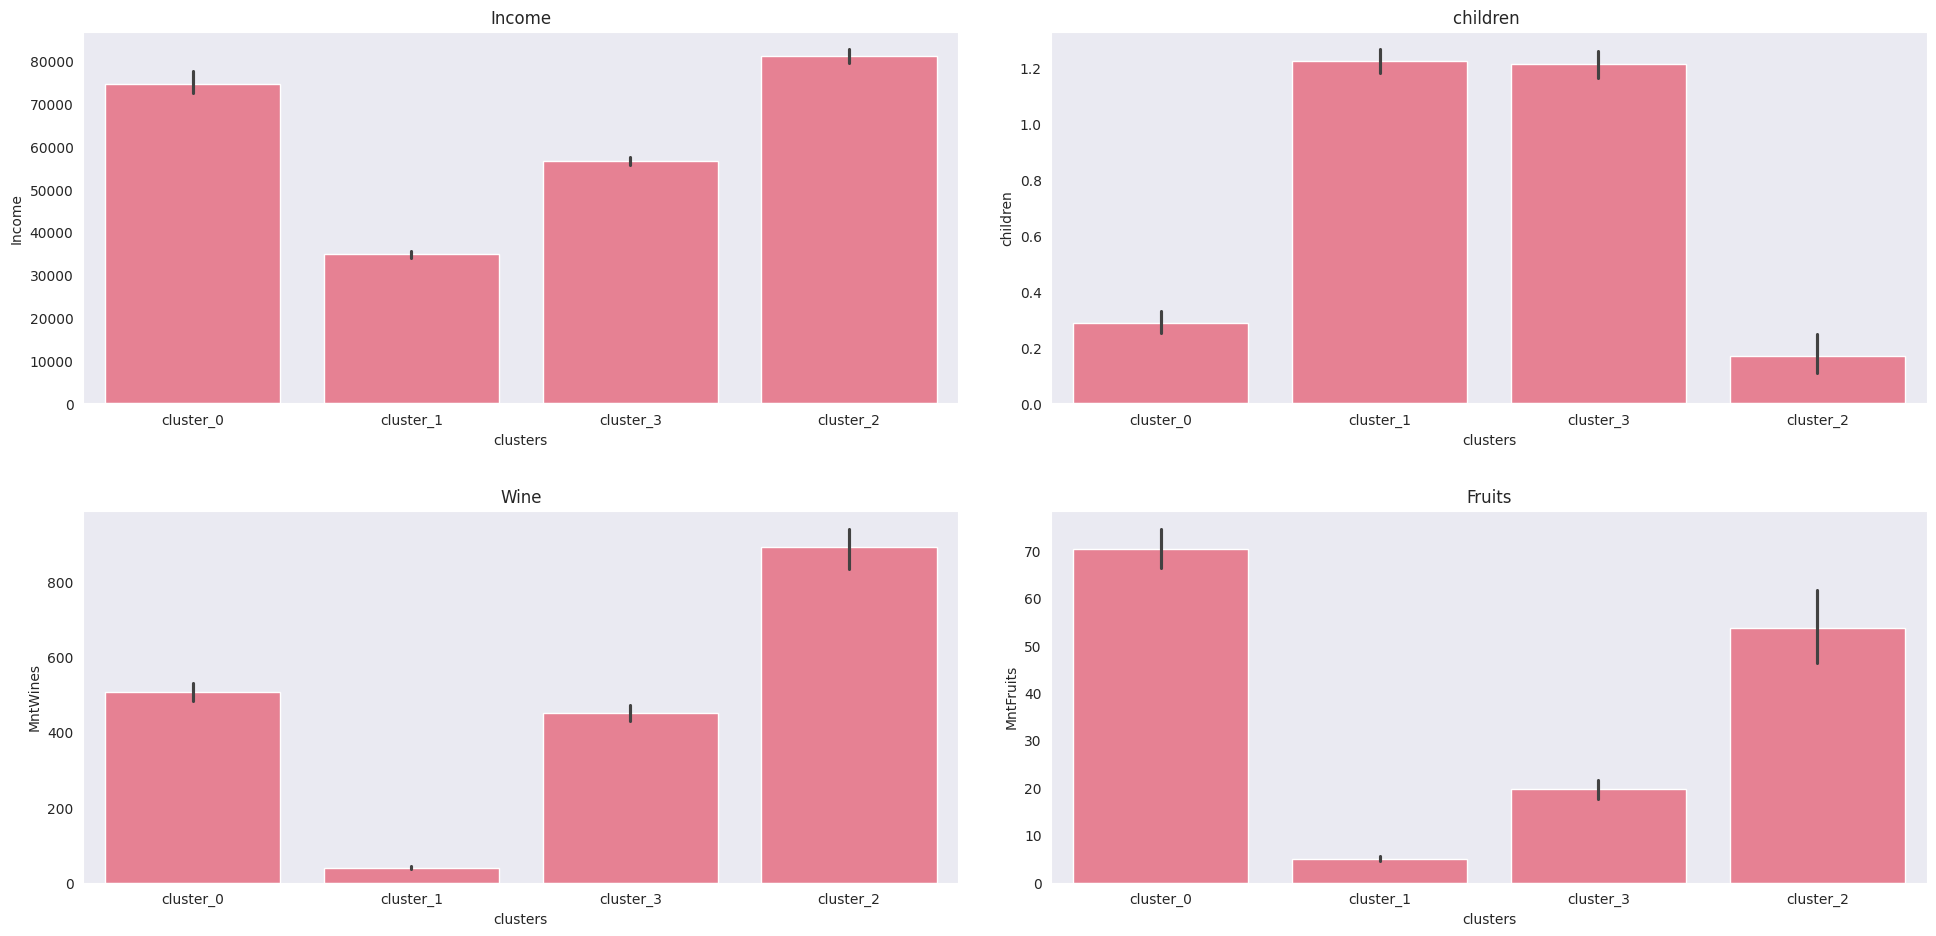

In [66]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.barplot(data = final_data, x = 'clusters',y = 'Income', ax=axes[0,0])
sns.barplot(data = final_data, x = 'clusters',y ='children', ax=axes[0,1])
sns.barplot(data = final_data, x = 'clusters',y = 'MntWines', ax=axes[1,0])
sns.barplot(data = final_data, x = 'clusters',y ='MntFruits', ax=axes[1,1])

axes[0,0].set_title('Income')
axes[0,1].set_title('children ')
axes[1,0].set_title('Wine')
axes[1,1].set_title('Fruits')

fig.tight_layout(pad = 3)

In [68]:
final_data[final_data['clusters'] == 'cluster_1']

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,customer_age,duration_of_patronage,clusters,children
1,Bsc,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,70,10,cluster_1,2
3,Bsc,dating,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,40,10,cluster_1,1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,43,10,cluster_1,1
7,PhD,Married,33454.0,1,0,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0,39,11,cluster_1,1
8,PhD,dating,30351.0,1,0,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1,50,11,cluster_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,Bsc,Married,24434.0,2,0,9,3,2,8,20,0,17,2,2,1,2,7,0,0,0,0,0,0,3,11,0,52,10,cluster_1,2
2230,Bsc,Single,11012.0,1,0,82,24,3,26,7,1,23,3,3,1,2,9,1,0,0,0,0,0,3,11,0,40,11,cluster_1,1
2232,Bsc,Single,26816.0,0,0,50,5,1,6,3,4,3,1,0,0,3,4,0,0,0,0,0,0,3,11,0,38,12,cluster_1,0
2234,Bsc,Married,34421.0,1,0,81,3,3,7,6,2,9,1,1,0,2,7,0,0,0,0,0,0,3,11,0,50,11,cluster_1,1


<Axes: xlabel='clusters', ylabel='count'>

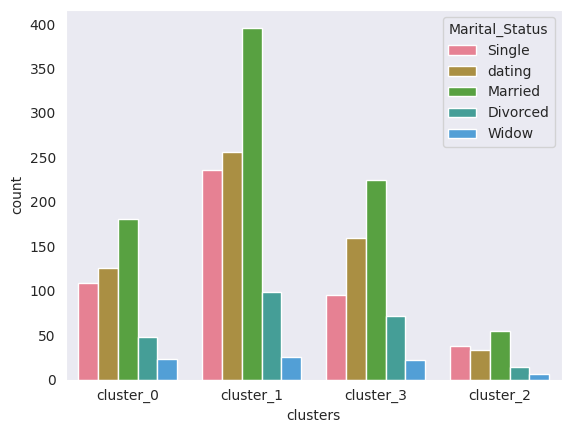

In [70]:
sns.countplot(data = final_data, x = 'clusters',hue ='Marital_Status')